In [1]:
import pandas as pd

# For CSV files:
data = pd.read_csv('spam_ham_dataset.csv')

In [2]:
print(data.head())
print(data['label'].value_counts())

   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  
label
ham     3672
spam    1499
Name: count, dtype: int64


In [3]:
data = data[['text', 'label_num']]
print(data.columns)

Index(['text', 'label_num'], dtype='object')


In [4]:
texts = data['text'].str.lower().tolist() #This gives you a list of all messages (each row of the column), ready for tokenization.

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()  # You can set num_words or other params here
tokenizer.fit_on_texts(texts)  # Learns the vocabulary from all messages

In [6]:
total_words = len(tokenizer.word_index) + 1
total_words

57872

In [7]:
sequences = tokenizer.texts_to_sequences(texts)

In [8]:
print(texts[0])      # "subject: win a free vacation now!"
print(sequences[0])  # [112, 45, 9, 211, 678, 33]

subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .
[9, 18, 1043, 44, 13702, 16, 15, 8, 679, 82, 3, 2, 434, 17, 2013, 10, 14, 409, 69, 36, 60, 9840, 176, 479, 687, 35, 54, 1, 33, 8749, 3298, 11, 28, 241, 131, 2151, 655, 3, 1202, 889, 438, 10, 53, 3299, 22, 37, 560, 1, 16, 170, 15, 603, 1610, 6, 4370, 1975]


In [9]:
import numpy as np

lengths = [len(x) for x in sequences]
max_sequence_len = int(np.percentile(lengths, 95))  # 95th percentile length
print(f"95th percentile max sequence length: {max_sequence_len}")

95th percentile max sequence length: 599


In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding='post')
padded_sequences

array([[    9,    18,  1043, ...,     0,     0,     0],
       [    9,    48,   148, ...,     0,     0,     0],
       [    9,  1440, 27147, ...,     0,     0,     0],
       ...,
       [    9,   704,   241, ...,     0,     0,     0],
       [    9,  1064,  9434, ...,     0,     0,     0],
       [    9,   907,   330, ...,     0,     0,     0]])

In [11]:
x = padded_sequences
y = data['label_num']

In [12]:
from sklearn.model_selection import train_test_split
 
labels = np.array(data['label_num'])

x_train, x_test, y_train, y_test = train_test_split(
    x,y, test_size=0.2, random_state=42
)

In [13]:
# Define early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [14]:
import tensorflow

opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
loss = tensorflow.keras.losses.BinaryCrossentropy() 

In [15]:
## Train our LSTM RNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout,GRU

## Define the model
model=Sequential()
model.add(Embedding(input_dim=total_words,output_dim=100,input_length=max_sequence_len))
model.add(LSTM(150,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(1,activation="sigmoid"))

# #Compile the model
model.compile(loss=loss,optimizer=opt,metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 599, 100)          5787200   
                                                                 
 lstm (LSTM)                 (None, 599, 150)          150600    
                                                                 
 dropout (Dropout)           (None, 599, 150)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               100400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 6038301 (23.03 MB)
Trainable params: 6038301 (23.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

In [23]:
## Train the model
history=model.fit(x_train,y_train,epochs=20,batch_size=32,validation_data=(x_test,y_test),verbose=1,callbacks=[early_stopping],class_weight=class_weights  )

Epoch 1/20
130/130 [==============================] - 215s 2s/step - loss: 0.0935 - accuracy: 0.9732 - val_loss: 0.1549 - val_accuracy: 0.9643
Epoch 2/20
130/130 [==============================] - 340s 3s/step - loss: 0.0715 - accuracy: 0.9857 - val_loss: 0.1471 - val_accuracy: 0.9556
Epoch 3/20
130/130 [==============================] - 457s 4s/step - loss: 0.0983 - accuracy: 0.9853 - val_loss: 0.1906 - val_accuracy: 0.9614
Epoch 4/20
130/130 [==============================] - 472s 4s/step - loss: 0.0558 - accuracy: 0.9927 - val_loss: 0.2318 - val_accuracy: 0.9507
Epoch 5/20
130/130 [==============================] - 462s 4s/step - loss: 0.0536 - accuracy: 0.9932 - val_loss: 0.2367 - val_accuracy: 0.9507


In [24]:
from sklearn.metrics import classification_report

y_pred_probs = model.predict(x_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print(classification_report(y_test, y_pred))

33/33 [==============================] - 16s 478ms/step
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       742
           1       0.89      0.96      0.92       293

    accuracy                           0.96      1035
   macro avg       0.94      0.96      0.95      1035
weighted avg       0.96      0.96      0.96      1035



In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_message(message, tokenizer, model, max_len):
    if not message.strip():
        print("Empty message provided.")
        return "Invalid Input", 0.0
    # Preprocess the input
    message = message.lower()
    seq = tokenizer.texts_to_sequences([message])
    padded = pad_sequences(seq, maxlen=max_len, padding='post')

    # Make prediction
    prob = model.predict(padded, verbose=0)[0][0]
    label = "Spam" if prob > 0.4 else "Not Spam"

    print(f"Prediction: {label} (Confidence: {prob:.4f})")
    return label, prob


In [33]:
predict_message("Congratulations! You've won a free iPhone!", tokenizer, model, max_sequence_len)
predict_message("Hey, are we still on for the meeting tomorrow?", tokenizer, model, max_sequence_len)


Prediction: Spam (Confidence: 0.5366)
Prediction: Not Spam (Confidence: 0.0079)


('Not Spam', 0.007918094)

In [34]:
predict_message("You have WON a FREE vacation! Click now!", tokenizer, model, max_sequence_len)


Prediction: Spam (Confidence: 0.4551)


('Spam', 0.45505035)

In [29]:
print(data['label_num'].value_counts())

label_num
0    3672
1    1499
Name: count, dtype: int64


In [35]:
model.save("spam_classifier_model.h5")

d:\Annie\SPAM_DETECTOR\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
import pickle

with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
import json

# Save
with open("config.json", "w") as f:
    json.dump({"max_sequence_len": max_sequence_len}, f)

33/33 [==============================] - 42s 912ms/step


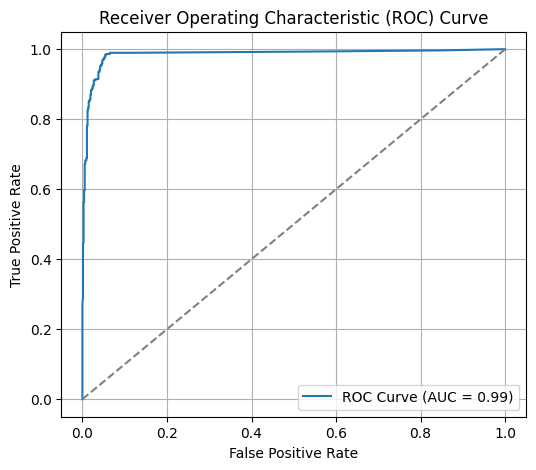

In [40]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get the predicted probabilities
y_pred_probs = model.predict(x_test).ravel()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

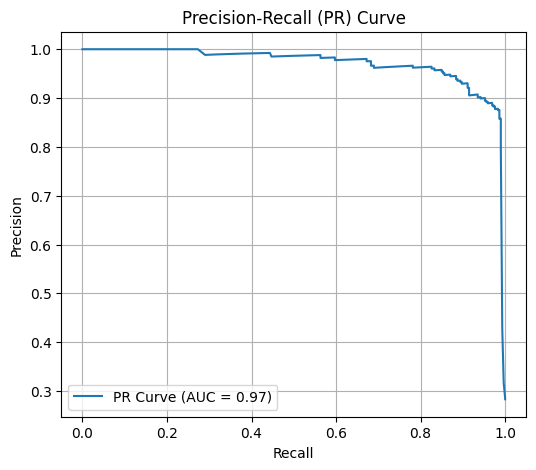

In [41]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall pairs and AUC
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probs)
pr_auc = average_precision_score(y_test, y_pred_probs)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall (PR) Curve")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()
